<h2 align=center> Named Entity Recognition (NER) using LSTMs with tensorflow.keras</h2>

### Task 1: Project Overview and Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
# plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.5.0-dev20201217
GPU detected: []


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [2]:
data = pd.read_csv("ner_dataset.csv.zip", compression='zip', encoding="latin1")
data = data.fillna(method="ffill")
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [4]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [5]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

### Task 3: Retrieve Sentences and Corresponsing Tags

In [6]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [7]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [8]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [9]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [10]:
word2idx

{'Hina': 1,
 'Erik': 2,
 'Outside': 3,
 'military-political': 4,
 'escapees': 5,
 'admiration': 6,
 '28th': 7,
 'Consensus': 8,
 'deflected': 9,
 'disguised': 10,
 'doves': 11,
 'relating': 12,
 'wings': 13,
 'useful': 14,
 'spacewalking': 15,
 'transitioning': 16,
 'disabling': 17,
 'requires': 18,
 'practices': 19,
 'Benita': 20,
 'similar': 21,
 'Potro': 22,
 'uranium-enrichment': 23,
 'Bell': 24,
 'mentions': 25,
 'loosened': 26,
 'talked': 27,
 'funnel': 28,
 'Scotland': 29,
 'parity': 30,
 'uproar': 31,
 'El-Obeid': 32,
 'Indonesian': 33,
 'uncertainty': 34,
 'Foreigners': 35,
 'moment': 36,
 'Palm': 37,
 '98': 38,
 'Javed': 39,
 'hemp': 40,
 'servicing': 41,
 'Cycling': 42,
 'Herb': 43,
 'Savannah': 44,
 'fine': 45,
 'Seventh': 46,
 'expect': 47,
 'Nyange': 48,
 'Spanish-language': 49,
 'eggplant': 50,
 'towers': 51,
 'lightly-populated': 52,
 '84.9': 53,
 'Nagin': 54,
 'Ghassan': 55,
 'Ansari': 56,
 '1644': 57,
 'non-aligned': 58,
 'Observer': 59,
 'Jawid': 60,
 'Reserve': 61,


### Task 5: Padding Input Sentences and Creating Train/Test Splits

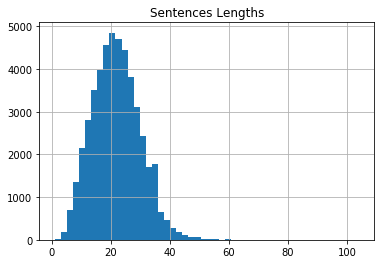

In [11]:
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Sentences Lengths')
plt.grid()
plt.show();

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [14]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [15]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### Task 7: Train the Model

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

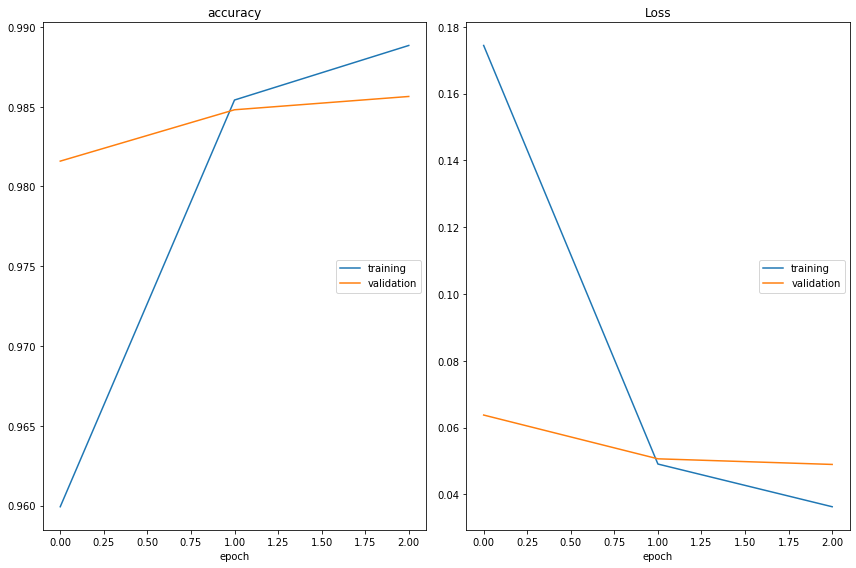

accuracy
	training         	 (min:    0.960, max:    0.989, cur:    0.989)
	validation       	 (min:    0.982, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.036, max:    0.174, cur:    0.036)
	validation       	 (min:    0.049, max:    0.064, cur:    0.049)

Epoch 00003: val_loss improved from 0.05067 to 0.04899, saving model to model_weights.h5
CPU times: user 16min 37s, sys: 3min 49s, total: 20min 26s
Wall time: 8min 49s


In [18]:
%%time

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=32, epochs=3,
                    callbacks=callbacks, verbose=1)

### Task 8: Evaluate Named Entity Recognition Model

In [19]:
model.evaluate(x_test, y_test)

300/300 [==============================] - 7s 24ms/step - loss: 0.0490 - accuracy: 0.9856


[0.04898533225059509, 0.9856421947479248]

In [25]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
Shaima         B-per	O
Rezayee        I-per	B-per
had            O	O
presented      O	O
a              O	O
music          O	O
program        O	O
on             O	O
the            O	O
privately-run  O	O
television     O	O
channel        O	O
Tolo           B-org	B-org
TV             I-org	I-org
,              O	O
and            O	O
was            O	O
shot           O	O
in             O	O
the            O	O
head           O	O
in             O	O
the            B-geo	O
Kabul          I-geo	B-geo
neighborhood   O	O
of             O	O
Char           B-org	O
Qala           I-org	I-org
on             O	O
Wednesday      B-tim	B-tim
.              O	O
out            O	O
out            O	O
out            O	O
out            O	O
out            O	O
out            O	O
out            O	O
out            O	O
out            O	O
out            O	O
out            O	O
out            O	O
out            O	O
out            O	O
out            O	O
out    